In [1]:
import sys
!{sys.executable} -m pip install sklearn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Load data from .txt files and make the train-test splits.
# Since we're working with text data, we need to vectorize the documents / turn each document
# into a point vector in a n-dimentions space. 
# Moreover, rather than simply using the word counts, we want to use the Term Frequency as feature value.

review_files = load_files('./cleaned_op_spam', encoding='latin-1')
x_train, x_test, y_train, y_test = train_test_split(review_files.data, review_files.target, test_size=0.2)

custom_stop_words = text.ENGLISH_STOP_WORDS.union(["\n"])
vectorizer = TfidfVectorizer(stop_words=custom_stop_words)
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)
# print(x_trainvec.toarray())
# print(vectorizer.get_feature_names_out())

print('===== Target classes =====')
print(review_files.target_names)
# print(review_files)

===== Target classes =====
['negative_deceptive', 'negative_truthful', 'positive_deceptive', 'positive_truthful']


In [4]:
review_files

{'data': ['My stay at the Hotel Monaco Chicago was amazing. The staff are polite and well poised, eager to give a helping hand in a short notice. To someone like me, who had never even been in the city of Chicago, it really gave me a good feeling throughout my whole trip. The rooms, hallways and facilities were exceptionally clean and tidy, and whenver I went out, I would always find my room perfect ; be it for a night of undwinding after one of my conferences, or just to hit the mattress and sleep. During my stay, I stopped at their restuarant where I had one of the best American style meal in a while. Overall, the Hotel Monaco is a place I would surely stay at again if given the chance to visit Chicago for a second time. It is truely exceptional.\n',
  "For the price, you would think this would be a top quality hotel, but it was nowhere close. Service at check-in was slow and unfriendly. The room was even worse. It was small, dirty and smelled like stale cigarette smoke even though I

In [5]:
# word frequency for ALL corpuses
import pandas as pd
c_vectorizer = CountVectorizer(stop_words=custom_stop_words)
all_words = c_vectorizer.fit_transform(review_files.data)
counts = pd.DataFrame(all_words.toarray(), columns=c_vectorizer.get_feature_names_out())
sorted_counts = counts.sum().sort_values(ascending=False)
print(sorted_counts)

hotel        3337
room         2820
chicago      1527
stay         1304
great         865
             ... 
pointless       1
earning         1
poised          1
poisonous       1
kisses          1
Length: 9284, dtype: int64


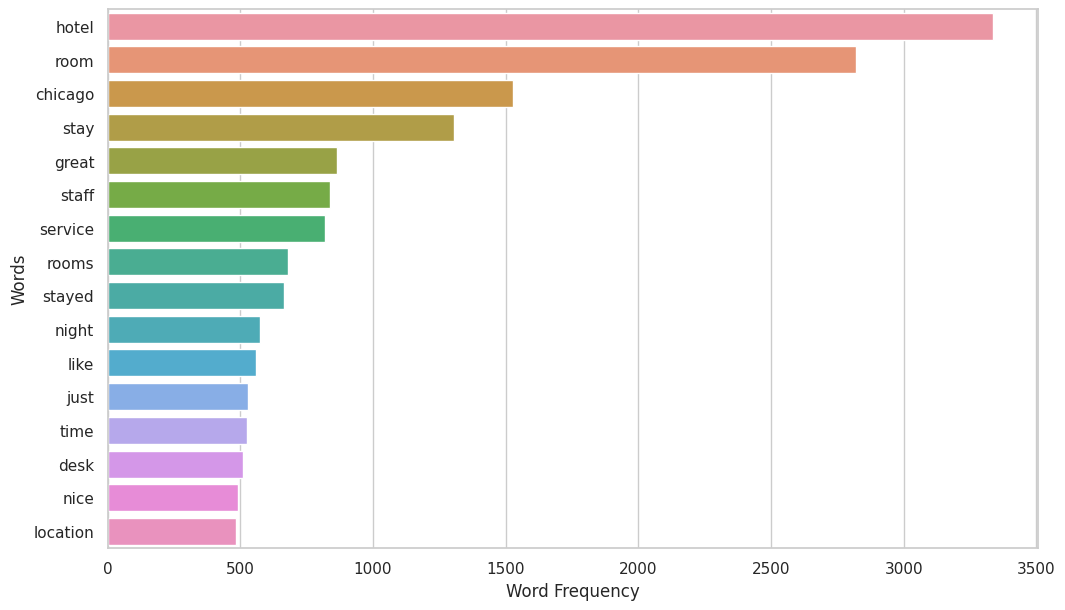

In [6]:
import seaborn as sns
limit = 16
custom_params = {'figure.figsize':(12,7)}
sns.set_theme(style="whitegrid", rc=custom_params)
ax = sns.barplot(y=sorted_counts.index[:limit], x=sorted_counts.values[:limit])
ax.set(xlabel='Word Frequency', ylabel='Words')
plt.show()

In [7]:
# Fit and test the models
mnb = MultinomialNB()
preds_mnb = mnb.fit(x_train_vec, y_train).predict(x_test_vec)
print("MNB correct predictions %d out of %d" % ((y_test == preds_mnb).sum(), x_test_vec.shape[0]))

loreg1 = LogisticRegression(solver='lbfgs')
preds_logreg1 = loreg1.fit(x_train_vec, y_train).predict(x_test_vec)
print("LReg-LBFGS correct predictions %d out of %d" % ((y_test == preds_logreg1).sum(), x_test_vec.shape[0]))

logreg2 = LogisticRegression(solver='liblinear')
preds_logreg2 = logreg2.fit(x_train_vec, y_train).predict(x_test_vec)
print(f"LReg-Liblinear correct predictions {(y_test == preds_logreg2).sum()} out of {x_test_vec.shape[0]}")

logreg3 = LogisticRegression(solver='saga')
preds_logreg3 = logreg3.fit(x_train_vec, y_train).predict(x_test_vec)
print(f"LReg-Saga correct predictions {(y_test == preds_logreg3).sum()} out of {x_test_vec.shape[0]}")

dectree = DecisionTreeClassifier()
preds_dectree = dectree.fit(x_train_vec, y_train).predict(x_test_vec)
print(f"Decision Tree correct predictions {(y_test == preds_dectree).sum()} out of {x_test_vec.shape[0]}")

rforest = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
preds_rforest = rforest.fit(x_train_vec, y_train).predict(x_test_vec)
print(f"Random Forest correct predictions {(y_test == preds_rforest).sum()} out of {len(y_test)}")

MNB correct predictions 245 out of 320
LReg-LBFGS correct predictions 251 out of 320
LReg-Liblinear correct predictions 247 out of 320
LReg-Saga correct predictions 252 out of 320
Decision Tree correct predictions 163 out of 320
Random Forest correct predictions 186 out of 320


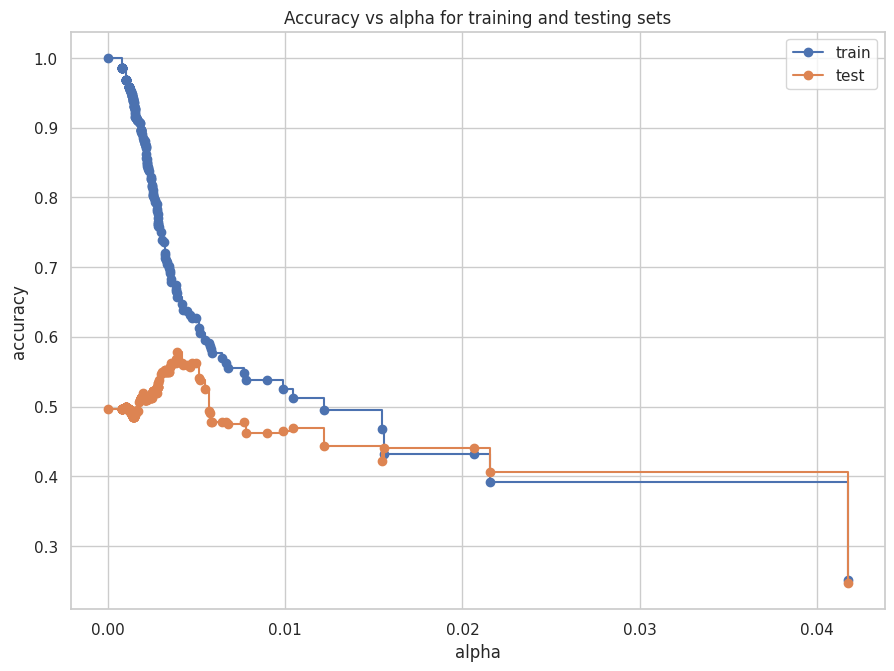

In [8]:
# Attempt to optimize the Decision Tree using Cost-Complexity Pruning technique
path = dectree.cost_complexity_pruning_path(x_train_vec, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
# print(ccp_alphas)
# print(impurities)

dtrees = []
for ccp_alpha in ccp_alphas:
    dtr = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    dtr.fit(x_train_vec, y_train)
    dtrees.append(dtr)
# print(f"Number of nodes in the last tree is: {dectrees[-1].tree_.node_count} with ccp_alpha: {ccp_alphas[-1]}")

train_scores = [dtr.score(x_train_vec, y_train) for dtr in dtrees]
test_scores = [dtr.score(x_test_vec, y_test) for dtr in dtrees]

fig, ax = plt.subplots()
fig.set_size_inches(10.5, 7.5)
fig.set_dpi(100)
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

# CONCLUSION: Accuracy optimizes at alpha 0.01. However, the score remains at ±52% so there is no noticeable 
# improvement achieved by the cost-complexity pruning, compared to the simple un-pruned tree.

In [13]:
# are these the most IMPORTANT words or just their frequency...?
# all probabilities are sorted
print(mnb.feature_log_prob_[:,:].argsort()[::-1])
np.set_printoptions(threshold=sys.maxsize)
print("All Feature Words:\n", vectorizer.get_feature_names_out())

range = 20
nt = mnb.feature_log_prob_[1, :].argsort()[::-1] # negative truthful
print("\nNegative Truthful:\n", np.take(vectorizer.get_feature_names_out(), nt[:range]))
pt = mnb.feature_log_prob_[3, :].argsort()[::-1] # positive truthful
print("Positive Truthful:\n", np.take(vectorizer.get_feature_names_out(), pt[:range]))

nd = mnb.feature_log_prob_[0, :].argsort()[::-1] # negative deceptive
print("\nNegative Deceptive:\n", np.take(vectorizer.get_feature_names_out(), nd[:range]))
pd = mnb.feature_log_prob_[2, :].argsort()[::-1] # positive deceptive
print("Positive Deceptive:\n", np.take(vectorizer.get_feature_names_out(), pd[:range]))

[[8297 3507 3506 6372 6374 3502 6376 3500 3508 3498 6377 6378 6379 6382
  3491 6383 3489 3497 3488 6371 6370 3530 3529 3528 3527 6361 6363 3524
  3510 3521 3519 3518 3517 6367 3515 6369 3512 3520 6360 3487 6384 3462
  3461 3460 3459 3458 3457 3456 3463 3455 6397 6398 3451 3450 3449 3448
  3447 6396 3485 6395 6393 3483 3482 6385 6386 6388 3477 3476 6394 6389
  3473 6390 6391 3470 6392 3468 3467 3474 6401 6359 3534 3593 3592 3591
  3590 3589 6322 6324 3594 6326 6329 3583 3582 6330 3580 3579 3578 3585
  6331 3595 6320 3613 3612 6314 3610 3609 3608 3607 6321 6315 3604 3603
  6317 3601 3600 6318 3598 6316 3533 6335 6337 6348 6349 3549 6350 6352
  3546 3545 3552 3544 3542 6354 3540 6355 6356 6358 3535 6353 6336 3553
  3555 6339 3571 3570 6342 3568 3567 6343 6347 3565 3563 6345 3561 3560
  3559 6346 3556 6344 3445 3444 3443 6457 6458 6459 6460 3325 3324 3323
  6456 3322 3320 3319 3318 3317 3316 3315 3314 3321 3313 6455 3334 3353
  3352 6444 3349 3348 3347 6445 6454 3345 6448 3342 6450 3340 33

In [10]:
def run_cross_validation(nfolds, ngram=1):
    tf_vectorizer = TfidfVectorizer(stop_words=custom_stop_words, ngram_range=(ngram, ngram))
    x_train_vec = tf_vectorizer.fit_transform(review_files.data)
    y_train_vec = review_files.target

    mnbayes = MultinomialNB()
    logreg = LogisticRegression(solver='lbfgs')
    logreg2 = LogisticRegression(solver='liblinear')
    logreg3 = LogisticRegression(solver='saga')
    dtree = DecisionTreeClassifier()
    ranForest = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
    
    # Naive Bayes
    bayes_acc = cross_val_score(mnbayes, x_train_vec, y_train_vec, cv=nfolds, scoring='accuracy', n_jobs=-1).mean()
    bayes_prec = 0 #cross_val_score(mnbayes, x_train_vec, y_train_vec, cv=nfolds, scoring='precision').mean()
    bayes_rec = 0 #cross_val_score(mnbayes, x_train_vec, y_train_vec, cv=nfolds, scoring='recall').mean()
    
    #Logistic regression
    lg_acc = cross_val_score(logreg, x_train_vec, y_train_vec, cv=nfolds, scoring='accuracy', n_jobs=-1).mean()
    lg_prec = 0 #cross_val_score(logreg, x_train_vec, y_train_vec, cv=nfolds, scoring='precision').mean()
    lg_rec = 0 #cross_val_score(logreg, x_train_vec, y_train_vec, cv=nfolds, scoring='recall').mean()
    
    lg2_acc = cross_val_score(logreg2, x_train_vec, y_train_vec, cv=nfolds, scoring='accuracy', n_jobs=-1).mean()
    lg2_prec = 0 #cross_val_score(logreg2, x_train_vec, y_train_vec, cv=nfolds, scoring='precision').mean()
    lg2_rec = 0 #cross_val_score(logreg2, x_train_vec, y_train_vec, cv=nfolds, scoring='recall').mean()
    
    lg3_acc = cross_val_score(logreg3, x_train_vec, y_train_vec, cv=nfolds, scoring='accuracy', n_jobs=-1).mean()
    lg3_prec = 0 #cross_val_score(logreg3, x_train_vec, y_train_vec, cv=nfolds, scoring='precision').mean()
    lg3_rec = 0 #cross_val_score(logreg3, x_train_vec, y_train_vec, cv=nfolds, scoring='recall').mean()
            
    dt_acc = cross_val_score(dtree, x_train_vec, y_train_vec, cv=nfolds, scoring='accuracy', n_jobs=-1).mean()
    dt_prec = 0 #cross_val_score(dtree, x_train_vec, y_train_vec, cv=nfolds, scoring='precision').mean()
    dt_rec = 0 #cross_val_score(dtree, x_train_vec, y_train_vec, cv=nfolds, scoring='recall').mean()
    
    ranForest_acc = cross_val_score(ranForest, x_train_vec, y_train_vec, cv=nfolds, scoring='accuracy', n_jobs=-1).mean()
    ranForest_prec = 0 #cross_val_score(ranForest, x_train_vec, y_train_vec, cv=nfolds, scoring='precision').mean()
    ranForest_rec = 0 #cross_val_score(ranForest, x_train_vec, y_train_vec, cv=nfolds, scoring='recall').mean()
    
    print(f'         Model                         | Accuracy | Precision | Recall')
    print(f'Naive Bayes                            | {round(bayes_acc, 3)}    | {round(bayes_prec, 3)}    | {round(bayes_rec, 3)}')
    print(f'Logistic Regression - LBFGS solver     | {round(lg_acc, 3)}    | {round(lg_prec, 3)}    | {round(lg_rec, 3)}')
    print(f'Logistic Regression - Liblinear solver | {round(lg2_acc, 3)}    | {round(lg2_prec, 3)}    | {round(lg2_rec, 3)}')
    print(f'Logistic Regression - Saga solver      | {round(lg3_acc, 3)}    | {round(lg3_prec, 3)}    | {round(lg3_rec, 3)}')
    print(f'Decision Tree                          | {round(dt_acc, 3)}    | {round(dt_prec, 3)}    | {round(dt_rec, 3)}')
    print(f'Random Forest                          | {round(ranForest_acc, 3)}    | {round(ranForest_prec, 3)}    | {round(ranForest_rec, 3)}')

In [11]:
print('===== UNIGRAM, 5 folds cv =====')
run_cross_validation(nfolds=5, ngram=1)
print('===== UNIGRAM, 10 folds cv =====')
run_cross_validation(nfolds=10, ngram=1)
print('\n===== BIGRAM, 5 folds cv =====')
run_cross_validation(nfolds=5, ngram=2)
print('\n===== BIGRAM, 10 folds cv =====')
run_cross_validation(nfolds=10, ngram=2)

===== UNIGRAM, 5 folds cv =====
         Model                         | Accuracy | Precision | Recall
Naive Bayes                            | 0.791    | 0    | 0
Logistic Regression - LBFGS solver     | 0.817    | 0    | 0
Logistic Regression - Liblinear solver | 0.817    | 0    | 0
Logistic Regression - Saga solver      | 0.818    | 0    | 0
Decision Tree                          | 0.514    | 0    | 0
Random Forest                          | 0.593    | 0    | 0
===== UNIGRAM, 10 folds cv =====
         Model                         | Accuracy | Precision | Recall
Naive Bayes                            | 0.795    | 0    | 0
Logistic Regression - LBFGS solver     | 0.823    | 0    | 0
Logistic Regression - Liblinear solver | 0.816    | 0    | 0
Logistic Regression - Saga solver      | 0.823    | 0    | 0
Decision Tree                          | 0.526    | 0    | 0
Random Forest                          | 0.579    | 0    | 0

===== BIGRAM, 5 folds cv =====
         Model               